## Incidence du syndrome varicelle

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek

Les données de l'incidence du syndrome grippal sont disponibles du site Web du [Réseau Sentinelles](http://www.sentiweb.fr/france/fr/?). Nous les récupérons sous forme d'un fichier en format CSV dont chaque ligne correspond à une semaine de la période demandée. Nous téléchargeons toujours le jeu de données complet, qui commence en 1991 et se termine avec une semaine récente.

In [ ]:
data_url = "http://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

Voici l'explication des colonnes données [sur le site d'origine](https://ns.sentiweb.fr/incidence/csv-schema-v1.json):
La première ligne du fichier CSV est un commentaire, que nous ignorons en précisant skiprows=1.

Pour nous protéger contre une éventuelle disparition ou modification du serveur du Réseau Sentinelles, nous faisons une copie locale de ce jeux de données que nous préservons avec notre analyse. Il est inutile et même risquée de télécharger les données à chaque exécution, car dans le cas d'une panne nous pourrions remplacer nos données par un fichier défectueux. Pour cette raison, nous téléchargeons les données seulement si la copie locale n'existe pas.

In [20]:
data_file = "syndrome-varicelle.csv"
import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

In [21]:
raw_data = pd.read_csv("syndrome-varicelle.csv", skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202119          7   8060     4941   11179      12           7   
1     202118          7   3932     2093    5771       6           3   
2     202117          7   4686     2878    6494       7           4   
3     202116          7   4780     2891    6669       7           4   
4     202115          7  11215     7627   14803      17          12   
5     202114          7  11197     7994   14400      17          12   
6     202113          7   9714     6289   13139      15          10   
7     202112          7  11520     8415   14625      17          12   
8     202111          7   9386     6678   12094      14          10   
9     202110          7   9056     6452   11660      14          10   
10    202109          7  10988     7938   14038      17          12   
11    202108          7  11281     8361   14201      17          13   
12    202107          7  13561    10315   16807      21          16   
13    202106          7  13401     9810   16992      20          15   
14    202105          7  12210     8988   15432      18          13   
15    202104          7  12026     8826   15226      18          13   
16    202103          7   8913     6375   11451      13           9   
17    202102          7   7795     5430   10160      12           8   
18    202101          7  10525     7750   13300      16          12   
19    202053          7  11978     8406   15550      18          13   
20    202052          7  12012     8285   15739      18          12   
21    202051          7  10564     7574   13554      16          11   
22    202050          7   7063     4744    9382      11           7   
23    202049          7   5026     3145    6907       8           5   
24    202048          7   6683     4312    9054      10           6   
25    202047          7   4999     2963    7035       8           5   
26    202046          7   3752     1963    5541       6           3   
27    202045          7   3696     2016    5376       6           3   
28    202044          7   4391     2375    6407       7           4   
29    202043          7   4376     2505    6247       7           4   
...      ...        ...    ...      ...     ...     ...         ...   
1559  199126          7  17608    11304   23912      31          20   
1560  199125          7  16169    10700   21638      28          18   
1561  199124          7  16171    10071   22271      28          17   
1562  199123          7  11947     7671   16223      21          13   
1563  199122          7  15452     9953   20951      27          17   
1564  199121          7  14903     8975   20831      26          16   
1565  199120          7  19053    12742   25364      34          23   
1566  199119          7  16739    11246   22232      29          19   
1567  199118          7  21385    13882   28888      38          25   
1568  199117          7  13462     8877   18047      24          16   
1569  199116          7  14857    10068   19646      26          18   
1570  199115          7  13975     9781   18169      25          18   
1571  199114          7  12265     7684   16846      22          14   
1572  199113          7   9567     6041   13093      17          11   
1573  199112          7  10864     7331   14397      19          13   
1574  199111          7  15574    11184   19964      27          19   
1575  199110          7  16643    11372   21914      29          20   
1576  199109          7  13741     8780   18702      24          15   
1577  199108          7  13289     8813   17765      23          15   
1578  199107          7  12337     8077   16597      22          15   
1579  199106          7  10877     7013   14741      19          12   
1580  199105          7  10442     6544   14340      18          11   
1581  199104          7   7913     4563   11263      14           8   
1582  199103          7  15387    10484   20290      27          18   
1583  199102          7  16277  

Y a-t-il des points manquants dans ce jeux de données ?

In [22]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

Pas de point manquants.

Nos données utilisent une convention inhabituelle: le numéro de semaine est collé à l'année, donnant l'impression qu'il s'agit de nombre entier. C'est comme ça que Pandas les interprète.
Un deuxième problème est que Pandas ne comprend pas les numéros de semaine. Il faut lui fournir les dates de début et de fin de semaine. Nous utilisons pour cela la bibliothèque isoweek.
Comme la conversion des semaines est devenu assez complexe, nous écrivons une petite fonction Python pour cela. Ensuite, nous l'appliquons à tous les points de nos donnés. Les résultats vont dans une nouvelle colonne 'period'.

In [23]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

raw_data['period'] = [convert_week(yw) for yw in raw_data['week']]

Il restent deux petites modifications à faire.
Premièrement, nous définissons les périodes d'observation comme nouvel index de notre jeux de données. Ceci en fait une suite chronologique, ce qui sera pratique par la suite.
Deuxièmement, nous trions les points par période, dans le sens chronologique.

In [25]:
periods = sorted_raw_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Les donnees sont propres.On regarde les donnees

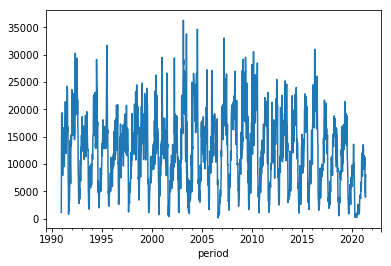

In [27]:
sorted_raw_data['inc'].plot()

on fait un zoom

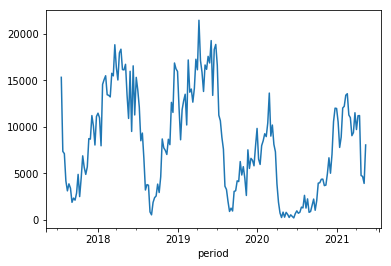

In [28]:
sorted_raw_data['inc'][-200:].plot()

## Etude de l'incidence annuelle

Etant donné que le pic de l'épidémie se situe en hiver, à cheval entre deux années civiles, nous définissons la période de référence entre deux minima de l'incidence, du 1er septembre de l'année $N$ au 1er septembre de l'année $N+1$.
Notre tâche est un peu compliquée par le fait que l'année ne comporte pas un nombre entier de semaines. Nous modifions donc un peu nos périodes de référence: à la place du 1er août de chaque année, nous utilisons le premier jour de la semaine qui contient le 1er août.
Comme l'incidence de syndrome grippal est très faible en été, cette modification ne risque pas de fausser nos conclusions.
Encore un petit détail: les données commencent an septembre 1991, ce qui rend la première année incomplète. Nous commençons donc l'analyse en 1991.

In [30]:
first_septembre_week = [pd.Period(pd.Timestamp(y, (9, 1), 'W')
                     for y in range(1991,
                                    sorted_raw_data.index[-1].year)]

SyntaxError: invalid syntax (<ipython-input-30-05d5f1bf4866>, line 3)